In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [ ]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torch
import cv2
import numpy as np
from torch.nn import functional as F
import torch.nn as nn

from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import random

In [ ]:
#파일이름 sort해서 list저장
data_path='/disk1/data_liverbound_noclip/'
name_list=os.listdir(data_path)

segmentation_data = [files[:-4] for files in name_list if files.startswith('segmentation')]
segmentation_data=list(set(segmentation_data))
segmentation_data.sort()
seg_data_test=[]
for i in range(30,45):
    seg_data_test.append(segmentation_data.pop(i))

volume_data=[files[:-4] for files in name_list if files.startswith('volume')]
volume_data=list(set(volume_data))
volume_data.sort()
vol_data_test=[]
for i in range(30,45):
    vol_data_test.append(volume_data.pop(i))

In [4]:
#npy를 slice별로 나누어 하나의 list저장

seg_list_test=[]

for file in seg_data_test:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        print(total_slices)
        # iterate through slices
        for current_slice in range(0, total_slices):
            seg_list_test.append(img_array[:,:,current_slice]) 
#간 1, 병변 2, 나머지 0


vol_list_test=[]

            
for file in vol_data_test:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        # iterate through slices
        for current_slice in range(0, total_slices):
            vol_list_test.append(img_array[:,:,current_slice]) 

volume-14
volume-16
volume-18
volume-2
volume-21
volume-23
volume-25
volume-27
volume-29
volume-30
volume-32
volume-34


In [5]:
#label을 만들어 list에 저장
labels_train = []
labels_test=[]
for i in seg_list_test:
    if 2 in i:
        labels_test.append(1)
    else:
        labels_test.append(0)
        


In [21]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    npy -= GLOBAL_PIXEL_MEAN
    
    if len(npy.shape)==2:
      npy=npy[:,:,np.newaxis].astype(dtype='float32')
    
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return npy,self.all_labels[idx]

In [22]:

transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])

test_dataset=CustomDataset(volume_list=vol_list_test, all_labels=seg_list_test,transforms=transforms_test)



In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__() #상속받은 class에 접근하기 위함

        self.layer1 = self.conv_module(1, 16) #흑백사진은 inp
        self.layer2 = self.conv_module(16, 32)
        self.layer3 = self.conv_module(32, 64)
        self.layer4 = self.conv_module(64, 128)
        self.layer5 = self.conv_module(128, 256)
        self.gap = self.global_avg_pool(256, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 2)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4))

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)))
        

In [25]:
model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load('/home/sumins/workspace/tumor_classification/model_check/model_dropout_position.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [11]:
print(model)

CustomConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.4, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padd

In [26]:
for i, j in model.named_children():
    print(i)
    print(j)
    print("-"*30)

layer1
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.4, inplace=False)
)
------------------------------
layer2
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.4, inplace=False)
)
------------------------------
layer3
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): MaxPool2d(kernel_size=2, stride=2, padd

In [13]:
class Extractor():
    def __init__(self, model):
        self.model = model
        self.gradients = []
        self.down_result = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def get_gradients(self):
        return self.gradients

    def __call__(self, x):
        self.gradients = []

        x.requires_grad_(True)

        
        for name,module1 in self.model.named_children():
            x=module1(x)
            if name=='layer4':  
                x.register_hook(self.save_gradient)
                target_feature_maps = x
                


        return target_feature_maps, x

class GradCam:
    def __init__(self, model, use_cuda):
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        else:
            self.model = model
        
        self.model.eval()
        self.extractor = Extractor(self.model)

    def __call__(self, input, class_num=1):
        if self.cuda:
            targets, output = self.extractor(input.cuda())
        else:
            targets, output = self.extractor(input)

        label = torch.zeros_like(output, dtype=torch.long)
        label[:, class_num] += 1

        if self.cuda:
            one_hot = torch.sum(label.cuda() * output)
        else:
            one_hot = torch.sum(label * output)
            
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        targets = targets.cpu().data.numpy()[0, :]
        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        
        grad_cam = np.zeros(targets.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            grad_cam += w * targets[i, :, :]

        grad_cam = cv2.resize(grad_cam, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        grad_cam = np.maximum(grad_cam, 0)
        cam_max, cam_min = np.max(grad_cam), np.min(grad_cam)
        if cam_max - cam_min > 0:
            grad_cam = (grad_cam - cam_min) / (cam_max - cam_min)
        else:
            grad_cam[:] = 0

        return (grad_cam * 255).astype('uint8')

In [27]:
CAM=GradCam(model,True)

True_label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], Pred_label: tensor([0], device='cuda:0')
True_label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], Pred_label: tensor([0], device='cuda:0')
True_label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], Pred_label: tensor([0], device='cuda:0')
True_label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], Pred_label: tensor([0], device='cuda:0')
True_label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], Pred_label: tensor([0], device='cuda:0')
True_label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]

/home/sumins/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


True_label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], Pred_label: tensor([0], device='cuda:0')


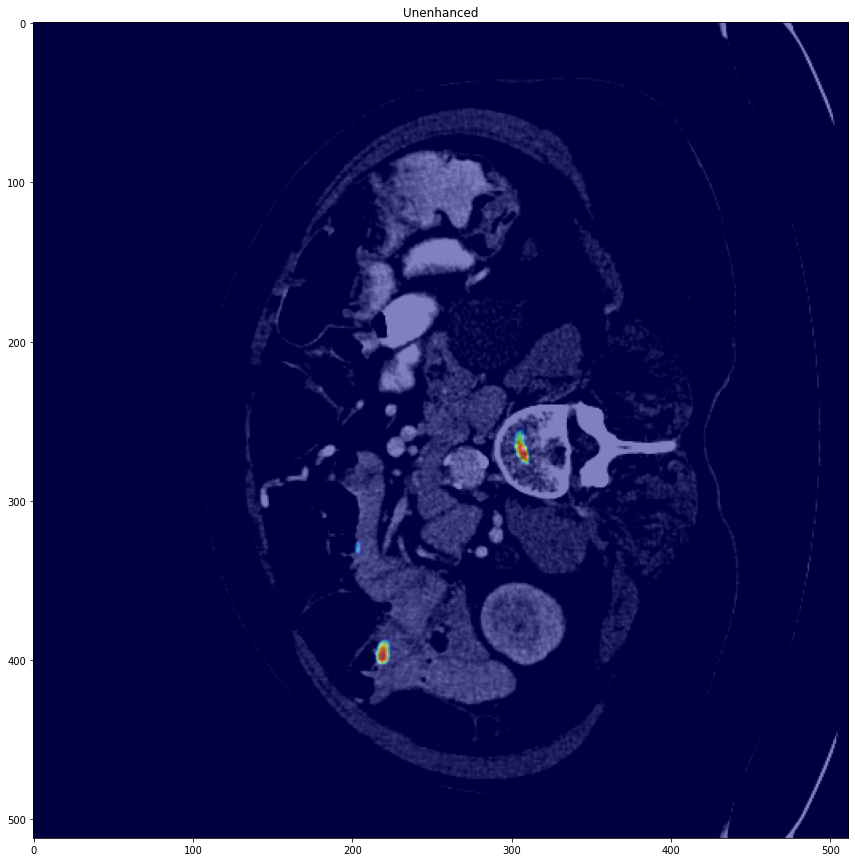

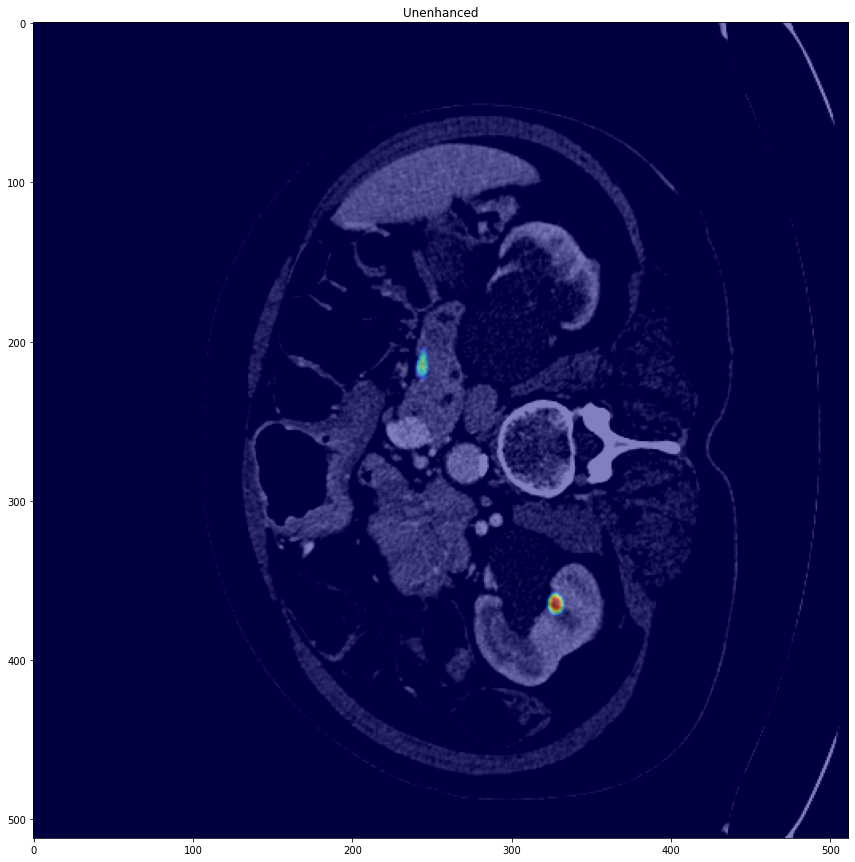

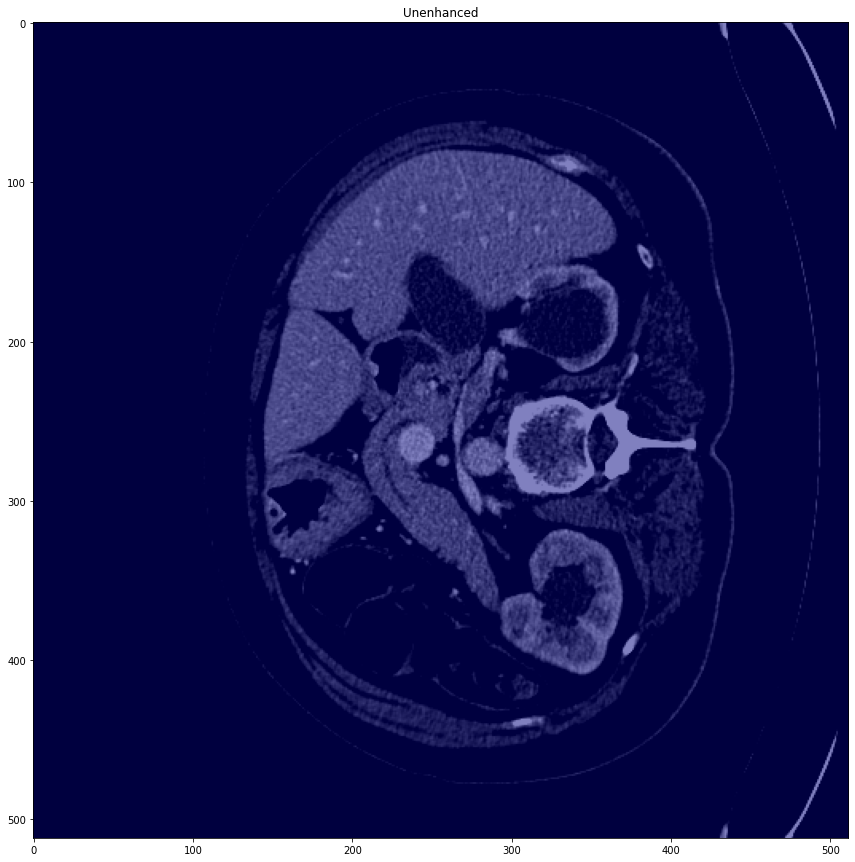

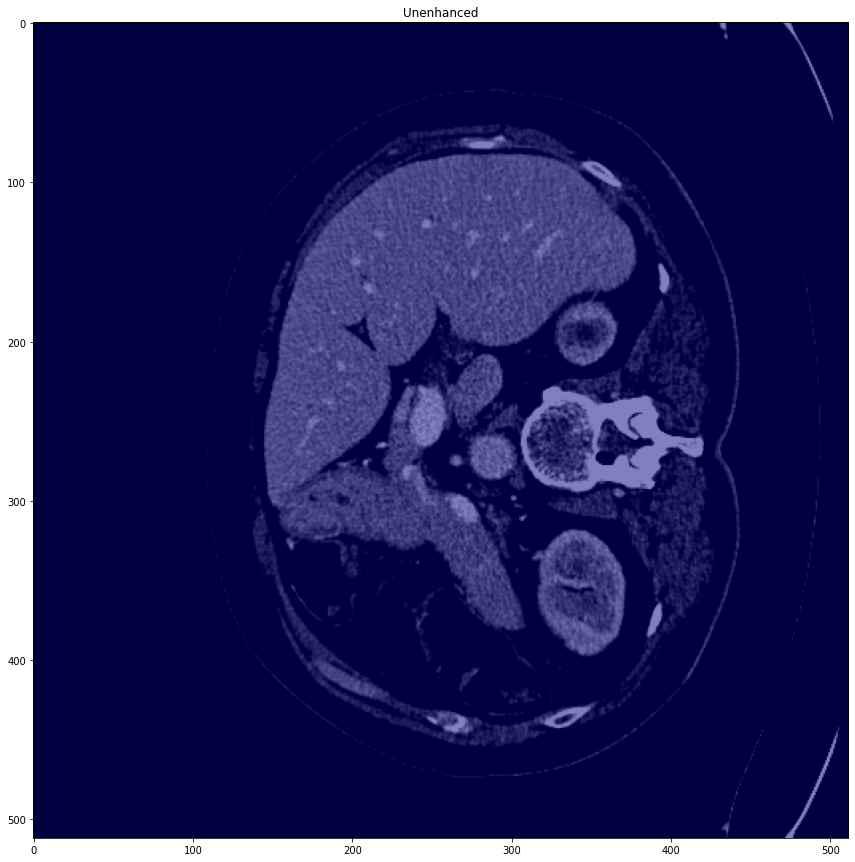

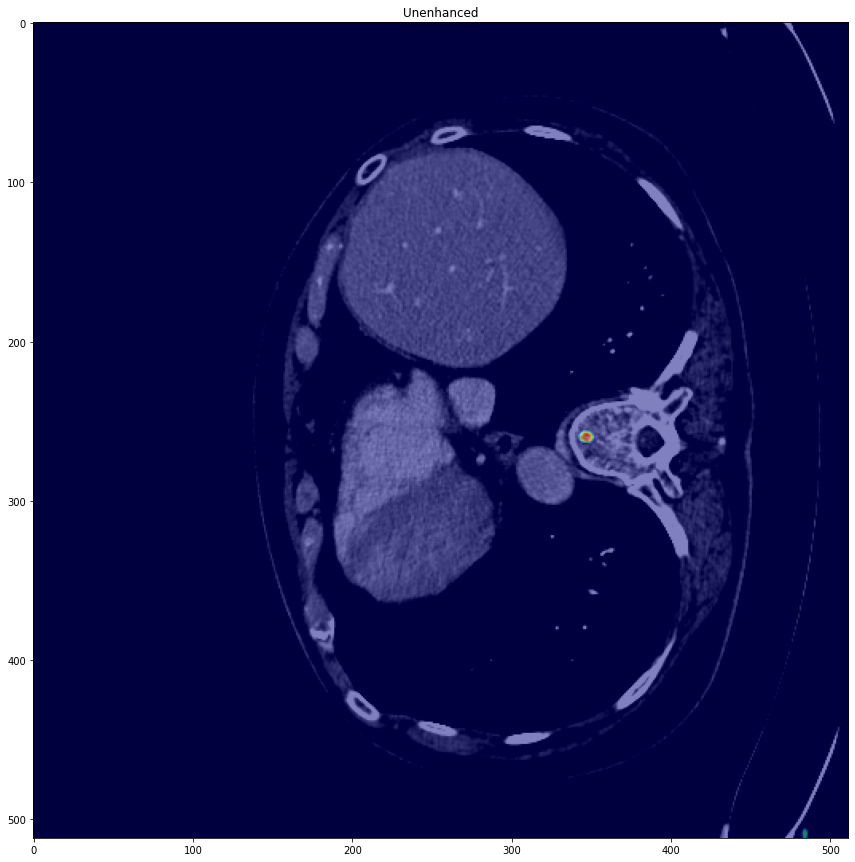

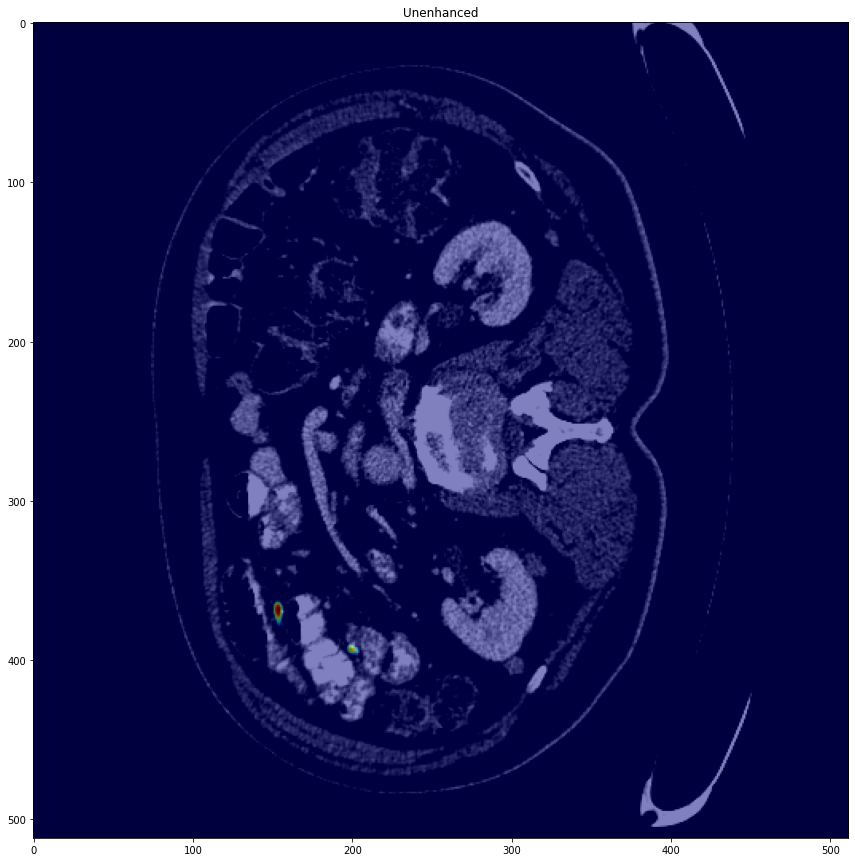

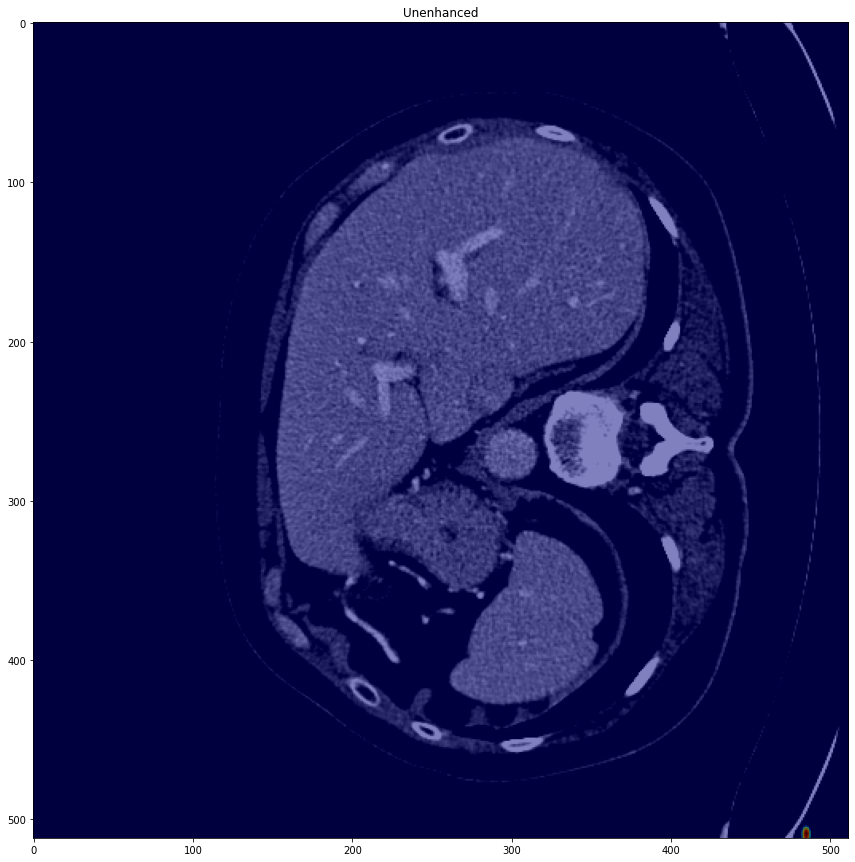

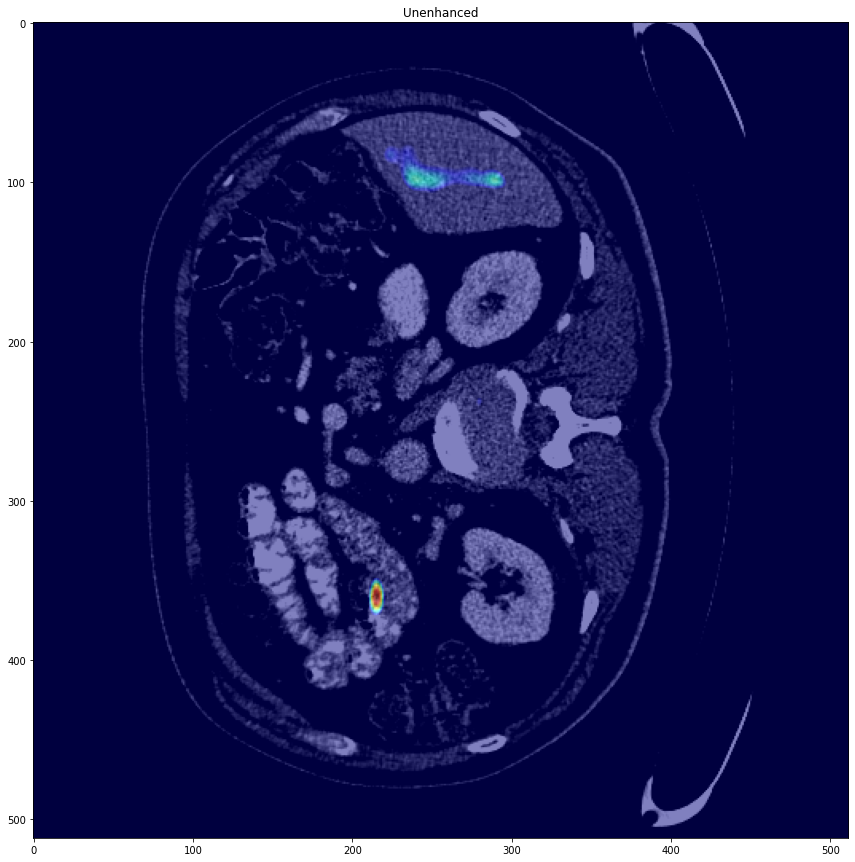

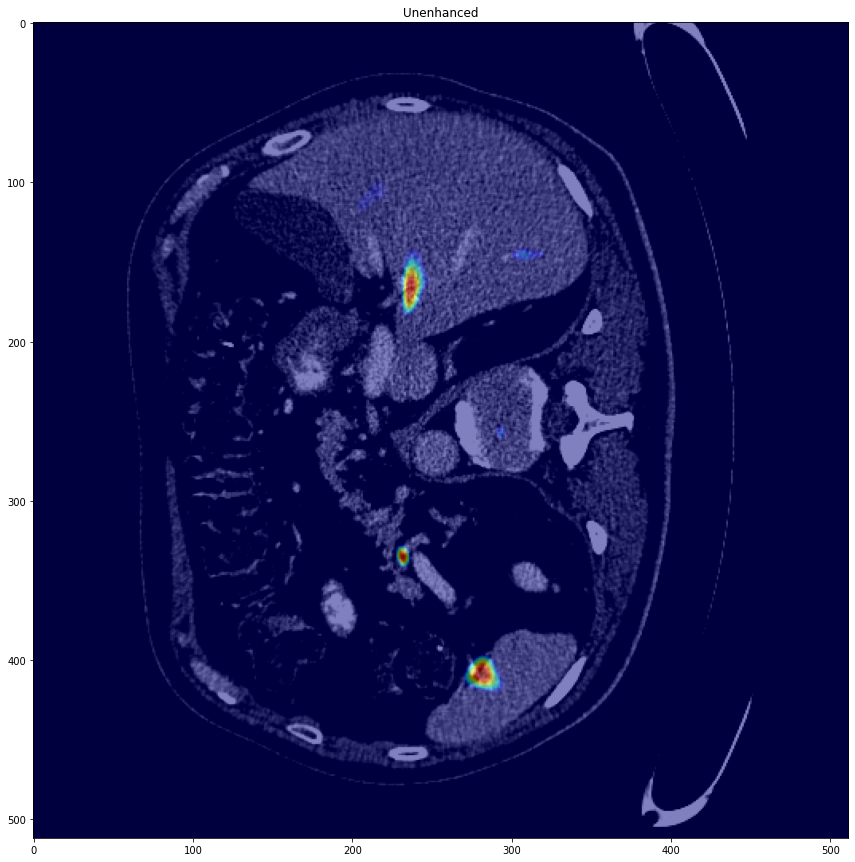

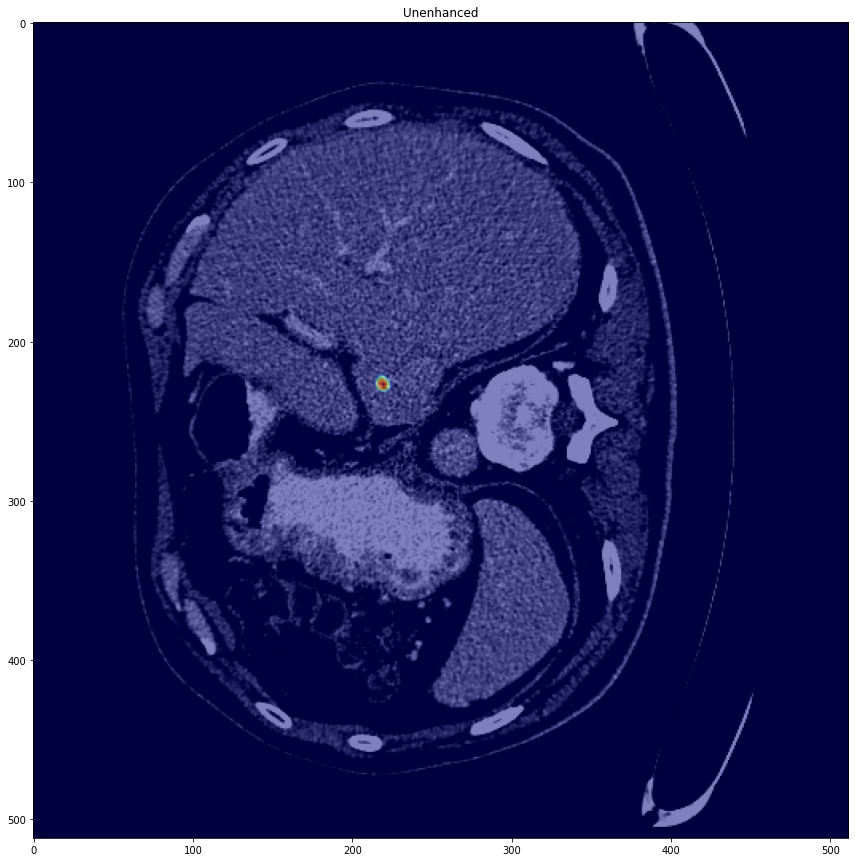

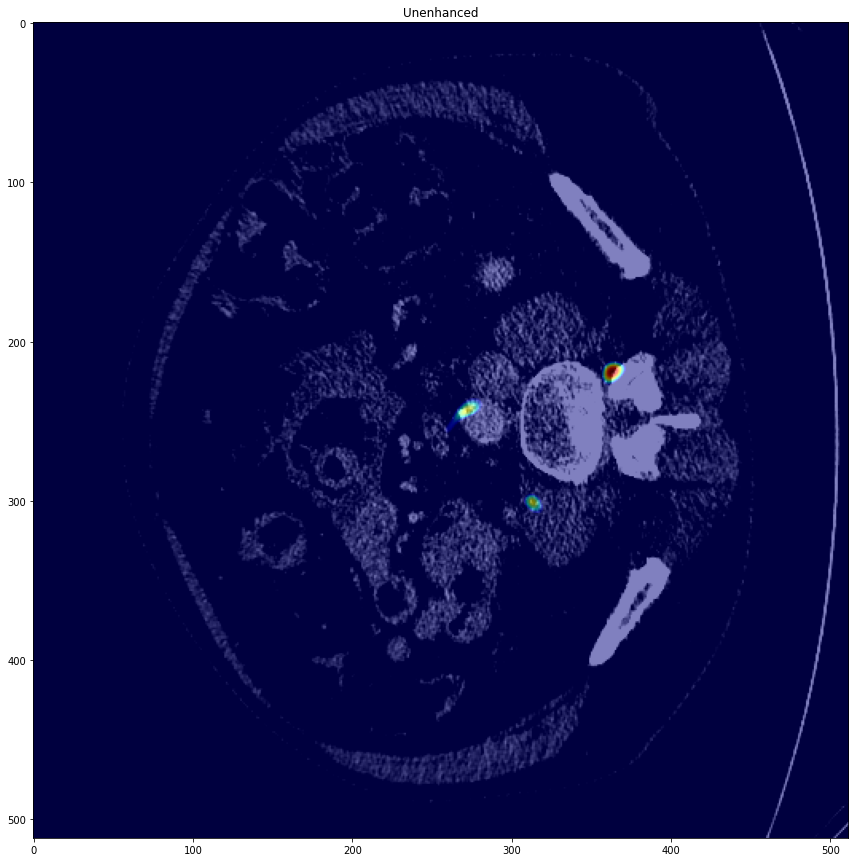

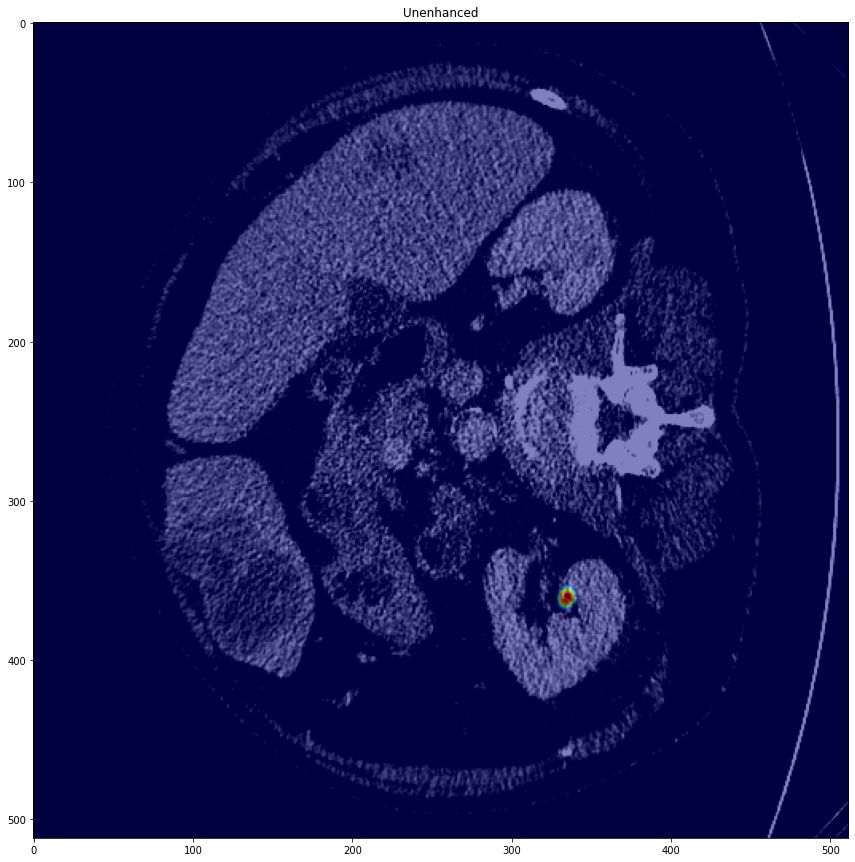

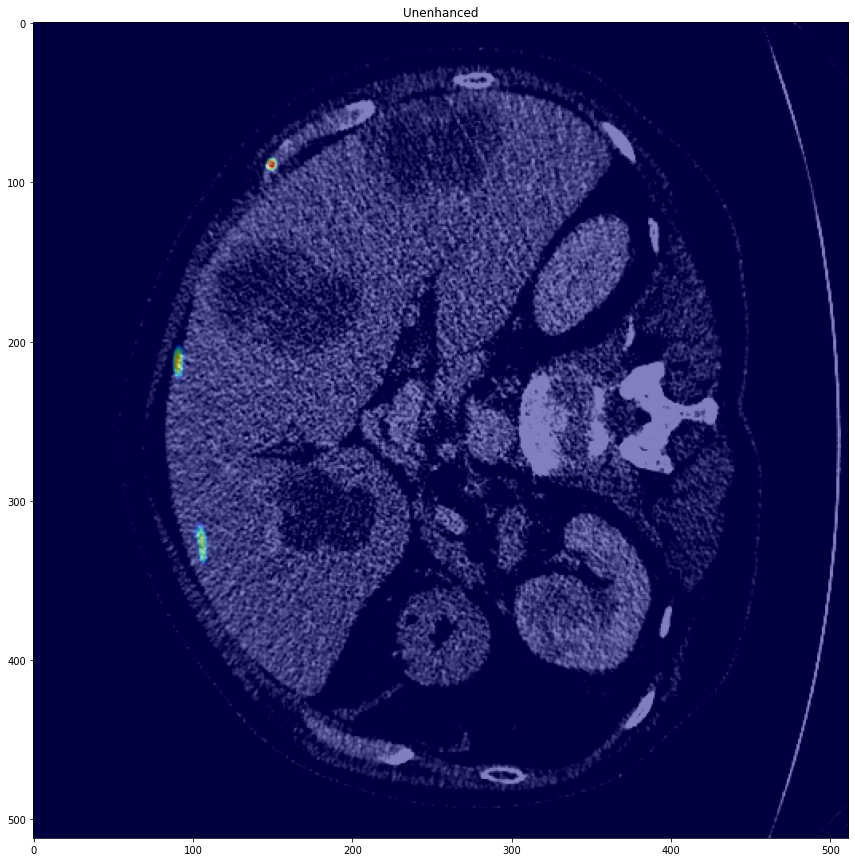

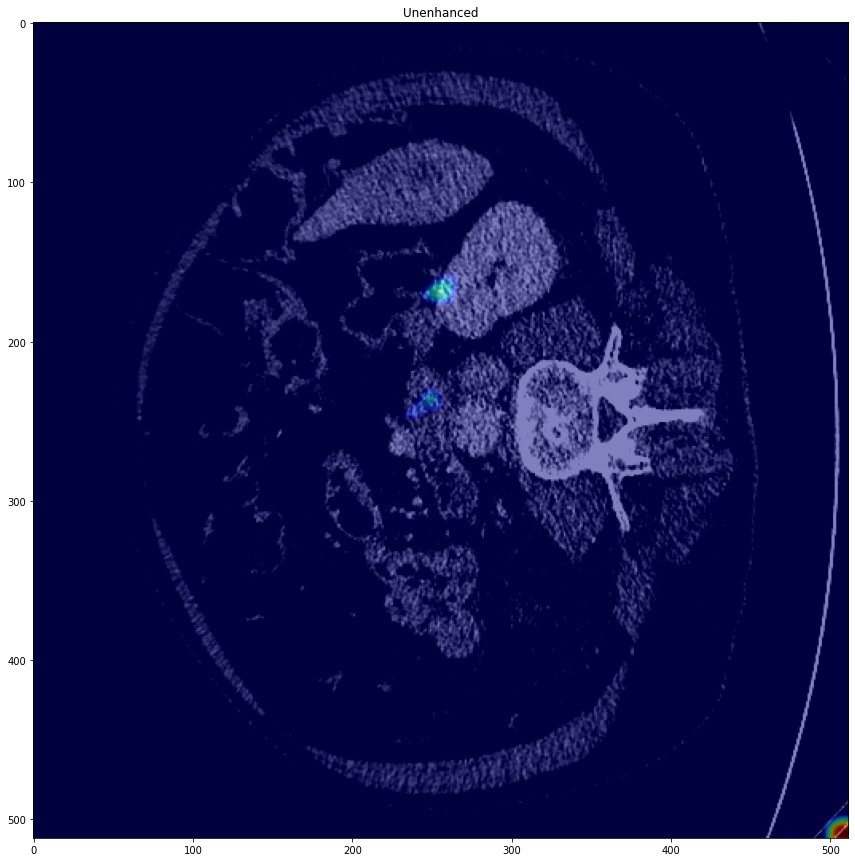

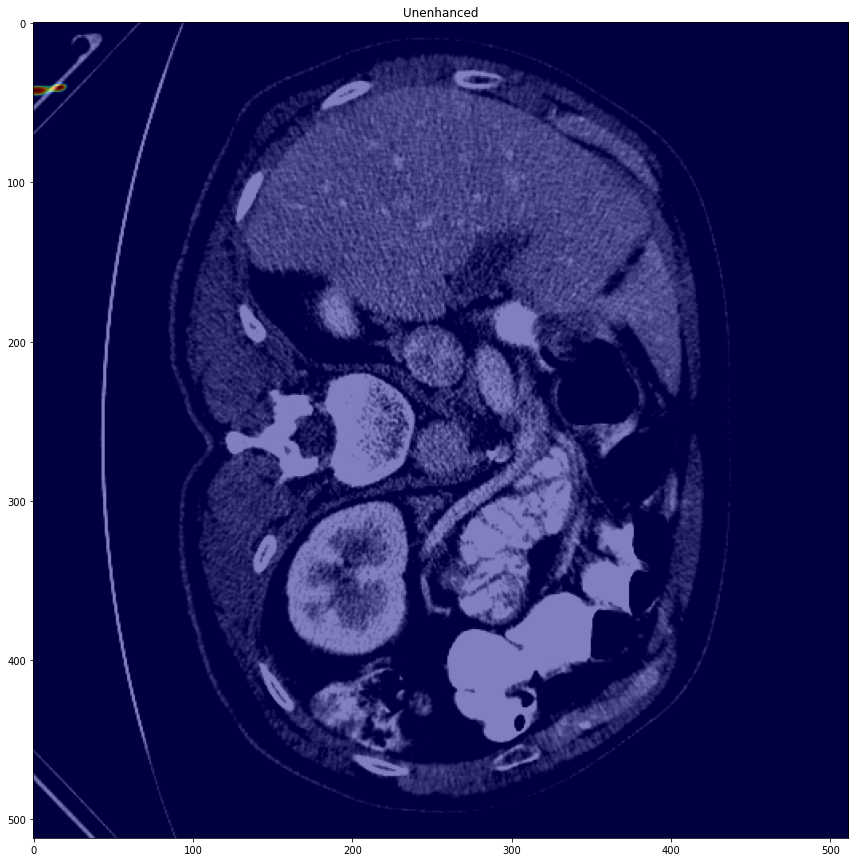

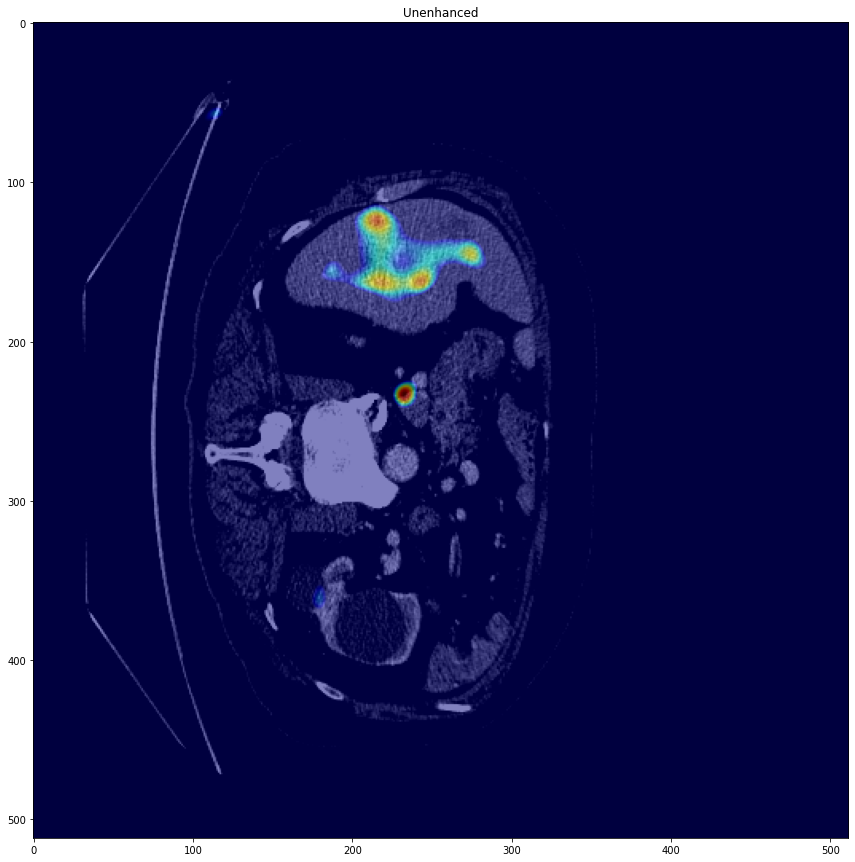

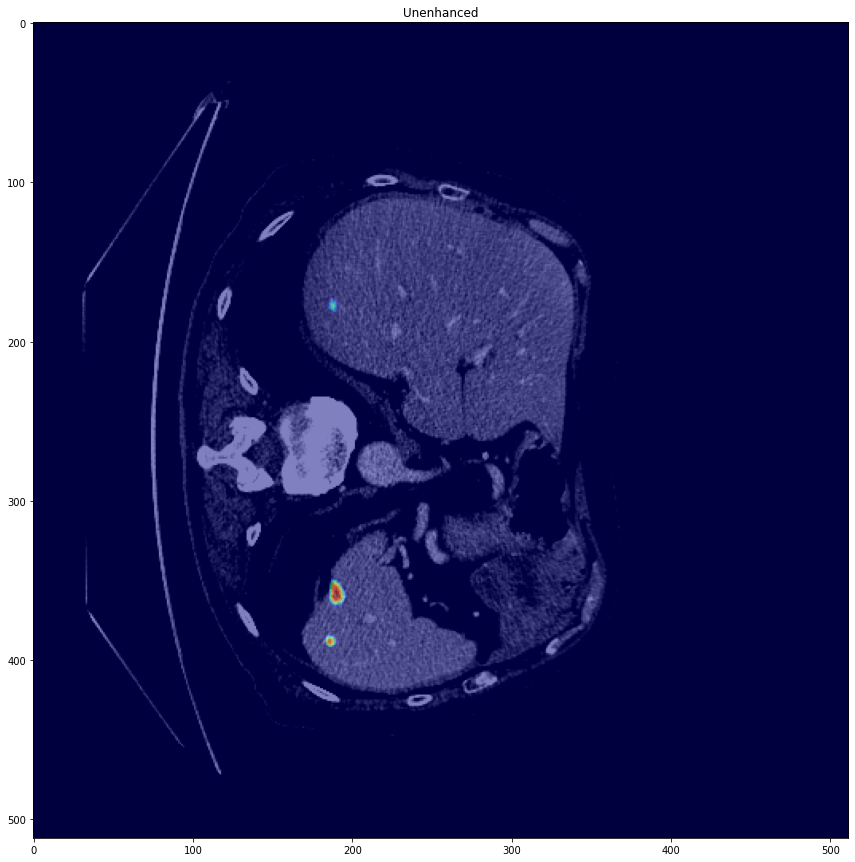

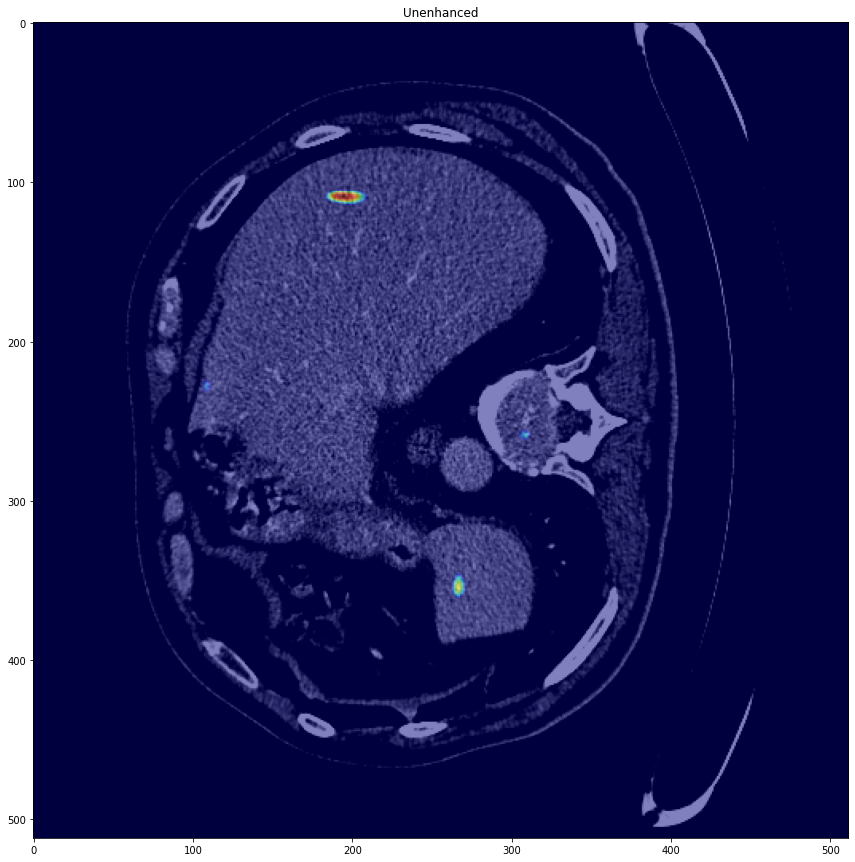

In [28]:
for i in [1,20,40,50 ,102, 150,71, 202,250,300,420,510,560,450,800,1200,1270,333,275,999,840,723,1102]:

    input, label=test_dataset[i]
   
    out = CAM(torch.unsqueeze(input, 0), 1)
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    output = model(torch.unsqueeze(input, 0).cuda())
    _, predicted = torch.max(output.data, 1)

    
    #print(output.shape)
    #pred = (F.sigmoid(output)[:, 1, :, :] > 0.5).type(torch.uint8)
    print("True_label: {}, Pred_label: {}".format(label, predicted))
    plt.figure(figsize=(15,15))
    plt.title('Unenhanced')
    plt.imshow(input[0], cmap='gray')
    plt.imshow(heatmap, alpha=0.5)


    # plt.title('Real Mask')
    # plt.imshow(mask, cmap='gray')
    # plt.subplot(2, 3, 6)
    # plt.title('Pred Mask')
    # plt.imshow(pred.cpu()[0], cmap='gray')

In [ ]:
for i in range(0,363):

    input, label=test_dataset[i]
    out = CAM(torch.unsqueeze(input, 0), 1)
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    output = model(torch.unsqueeze(input, 0).cuda())
    _, predicted = torch.max(output.data, 1)
    if predicted.item()==0:
        
        #print(output.shape)
        #pred = (F.sigmoid(output)[:, 1, :, :] > 0.5).type(torch.uint8)
        print("True_label: {}, Pred_label: {}".format(label, predicted))
        plt.figure(figsize=(15,15))
        plt.subplot(1,4,1)
        plt.title('Unenhanced')
        plt.imshow(input[1, :, :], cmap='gray')
        plt.imshow(heatmap, alpha=0.4)
        plt.subplot(1,4,2)
        plt.title('Arterial')
        plt.imshow(input[0, :, :], cmap='gray')
        plt.imshow(heatmap, alpha=0.4)
        plt.subplot(1,4,3)
        plt.title('Portal')
        plt.imshow(input[3, :, :], cmap='gray')
        plt.imshow(heatmap, alpha=0.4)
        plt.subplot(1,4,4)
        plt.title('Delay')
        plt.imshow(input[2, :, :], cmap='gray')
        plt.imshow(heatmap, alpha=0.4)
        plt.show()


    # plt.title('Real Mask')
    # plt.imshow(mask, cmap='gray')
    # plt.subplot(2, 3, 6)
    # plt.title('Pred Mask')
    # plt.imshow(pred.cpu()[0], cmap='gray')